# USE this notebook, not 8

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy as sp
import pylab as pl
import scipy.optimize
from scipy.stats import spearmanr
from IPython.display import Image 
ISH_data_processed=pd.read_csv('data/ISH_processed_data_strict.csv')
allen_brain_reg_coords=pd.read_csv('data/allen_brain_reg_coords.csv')
allen_brain_reg_coords.drop('Unnamed: 0',axis=1,inplace=True)

C:\Users\Kat\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\Kat\anaconda3\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
C:\Users\Kat\anaconda3\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
node_input =['PL', 'ILA', 'ORB', 'GU', 'AI', 'MOs', 'MOp','GPe','GPi','STRd','PALv',
             'BST','MEA', 'AAA', 'NLOT', 'COA', 'BMA', 'NDB','PVH','LH','MH','CEA',
             'LHA','ZI','DR','PAG','LDT','PB','CBN','ACB','LPO','MPO','MS','LSX','MA','EPv']
#using allen abbreviations
ROI_ISH_data=ISH_data_processed.loc[ISH_data_processed['brain_region'].isin(node_input)].drop('Unnamed: 0',axis=1)
#delete unnamed empty column
ROI_ISH_data= ROI_ISH_data.set_index(['brain_region']) #set brain region as index
len(node_input)

36

In [3]:
ROI_ISH_dat_t=ROI_ISH_data.T
brain_regions=ROI_ISH_dat_t.columns
genes=ROI_ISH_dat_t.index 

In [4]:
#ROI_ISH_data.to_csv('ISH_processed_data_ROI_only.csv')

# Correlation of processed gene expression data - NOT spatially corrected

Text(0.5, 0.98, 'NOT SPATIALLY CORRECTED!! GENE CORRELATION')

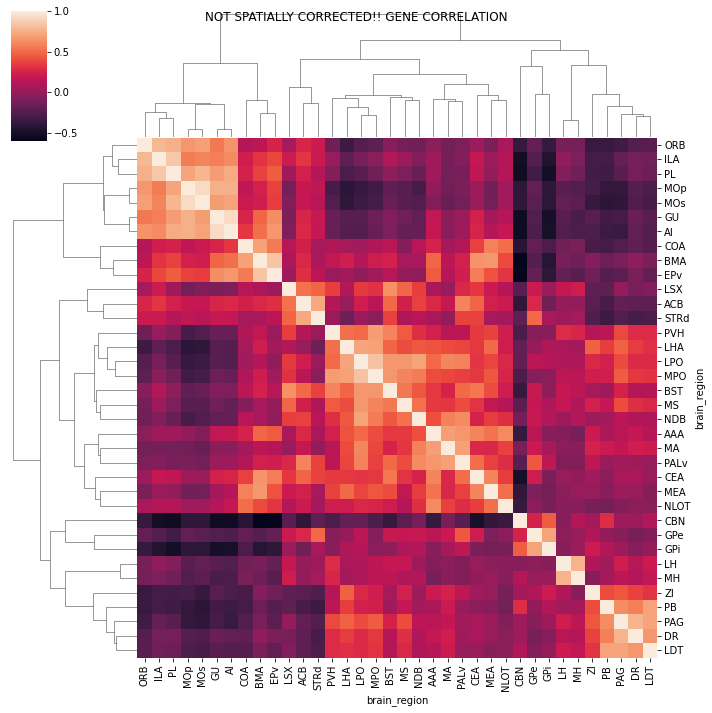

In [5]:
correlation_by_reg=ROI_ISH_dat_t.corr(method='spearman').values
corr_df= pd.DataFrame(correlation_by_reg,index=brain_regions,columns=brain_regions)
cm = sns.clustermap(corr_df,yticklabels=True,xticklabels=True)
cm.fig.suptitle("NOT SPATIALLY CORRECTED!! GENE CORRELATION")

In [6]:
distancedf = pd.DataFrame(index=allen_brain_reg_coords['brain_region']) #init distances dataframe
for n in range(len(allen_brain_reg_coords)):
    regn=allen_brain_reg_coords['brain_region'][n]
    xn=allen_brain_reg_coords['x_vox'][n]
    yn=allen_brain_reg_coords['y_vox'][n]
    zn=allen_brain_reg_coords['z_vox'][n] #get the individual x/y/z value
    xall=allen_brain_reg_coords['x_vox'] 
    yall=allen_brain_reg_coords['y_vox']
    zall=allen_brain_reg_coords['z_vox'] #get list of all x/y/z values
    xdif=xn-xall
    ydif=yn-yall
    zdif=zn-zall # get difference
    x_sq = [number ** 2 for number in xdif] #square dif
    y_sq = [number ** 2 for number in ydif]
    z_sq = [number ** 2 for number in zdif]
    zipped = zip(x_sq,y_sq,z_sq) #zip squared difs
    sums = [x + y + z for (x,y,z) in zipped]
    distances = [number ** 0.5 for number in sums] # take sq rt
    distancedf[regn]=distances

# Distances (voxels) heatmap

C:\Users\Kat\anaconda3\lib\site-packages\seaborn\matrix.py:619: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,


Text(0.5, 0.98, 'Distances heatmap (region center to region center)')

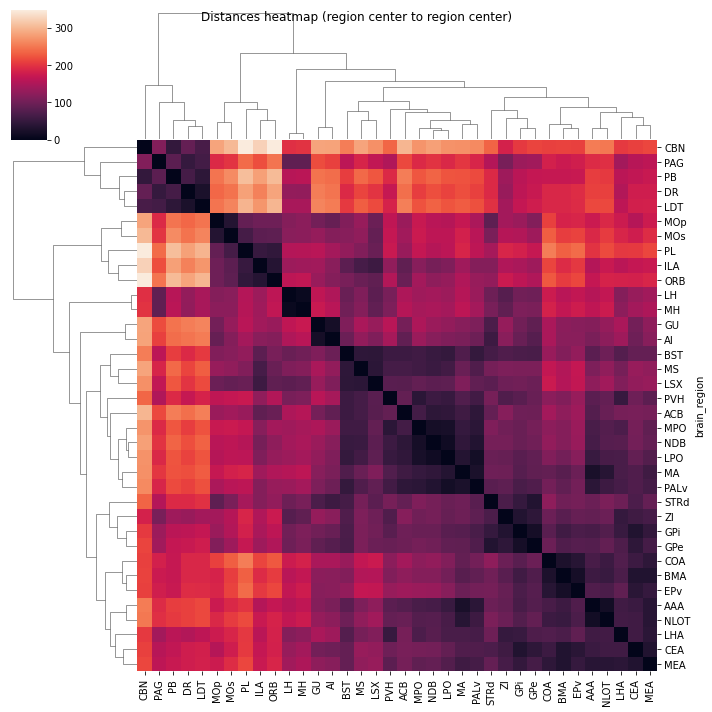

In [7]:
cm = sns.clustermap(distancedf,yticklabels=True,xticklabels=True)
cm.fig.suptitle("Distances heatmap (region center to region center)")

In [8]:
gene_Exp_regs=corr_df.columns.values
for n in allen_brain_reg_coords['brain_region']:
    if n in gene_Exp_regs:
        continue
    else:
        print('missing: '+str(n))  #check nothing missing

In [9]:
distancedf.shape #check it's same size

(36, 36)

In [10]:
len(node_input) # check it's same size

36

# Spatial correction process

In [11]:
corr_df2=corr_df.sort_values('brain_region')
corr_df2.sort_index(axis=1,inplace=True) #sort alphabetical both ways
#keep bottom left corner
corrmat=corr_df2.to_numpy()
corrmat[np.tril_indices(corrmat.shape[0], -1)] = np.nan
#convert to 1d to plot
corrmat2=corrmat.flatten()
corrmat3 = corrmat2[~np.isnan(corrmat2)]

In [12]:
distancedf2=distancedf.sort_values('brain_region') 
distancedf2.sort_index(axis=1,inplace=True) #sort alphabetical both ways
#keep bottom left corner
distmat=distancedf2.to_numpy()
distmat[np.tril_indices(distmat.shape[0], -1)] = np.nan
#convert to 1d to plot
distmat2=distmat.flatten()
distmat3 = distmat2[~np.isnan(distmat2)]

array([0.02055928])

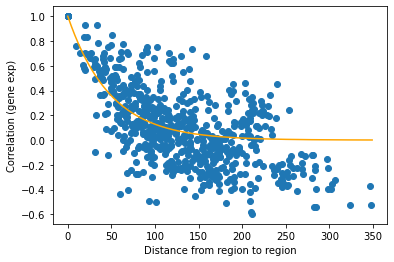

In [13]:
plt.scatter(distmat3,corrmat3) #show points
plt.xlabel('Distance from region to region')
plt.ylabel('Correlation (gene exp)')
#fit exponential decay as done https://www.pnas.org/content/113/5/1435/tab-figures-data
#assume decays to zero and max correlation at dist=1 (aka self is same as self)
def expdecay(x, param):
    return np.exp(-param * x) #only one param as done in above paper
param1, curv = scipy.optimize.curve_fit(expdecay, distmat3,corrmat3,0) 
#lower than paper value due to me using voxel dist not mm

#show exp decay 
x=np.arange(0,350)
plt.plot(x, expdecay(x,param1), c='orange')
#x is distance
#y is correlation of region to another region based on gene expression
param1

# Correlation of processed gene expression data - spatially corrected

Text(0.5, 0.98, 'SPATIALLY CORRECTED! GENE CORRELATION')

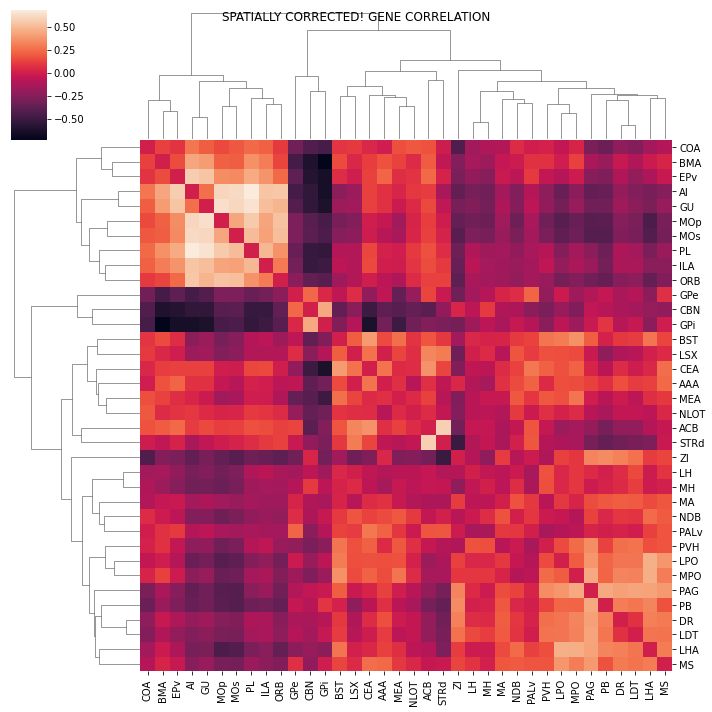

In [14]:
sorted_regs=sorted(brain_regions) #should be alphabetical 
distancedf2=distancedf.sort_values('brain_region') 
distancedf2.sort_index(axis=1,inplace=True) #sort alphabetical both ways
corr_df2=corr_df.sort_values('brain_region')
corr_df2.sort_index(axis=1,inplace=True) #sort alphabetical both ways

#spatial_corrected_corr = correlation - exp(param*dist) 
spatially_corrected=corr_df2.to_numpy() - expdecay(distancedf2.to_numpy(),param1)
corr_spatial_df= pd.DataFrame(spatially_corrected,index=sorted_regs,columns=sorted_regs)
cm = sns.clustermap(corr_spatial_df,yticklabels=True,xticklabels=True)
cm.fig.suptitle("SPATIALLY CORRECTED! GENE CORRELATION")

# Convert allen regions to Kevin regions and redo above - first non-spatial correction

Text(0.5, 0.98, 'NOT SPATIALLY CORRECTED!! GENE CORRELATION')

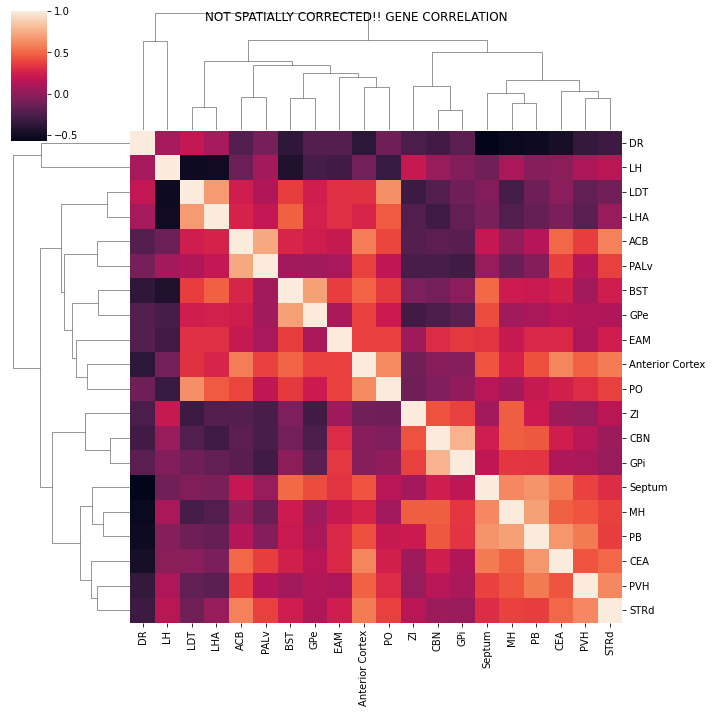

In [15]:
# dats=ROI_ISH_data['Pvalb'].values
# #ant cor sum sum PL ILA, ORB, GU, AI, MOs, MOp   ###
# #EAM sum MEA, AAA, NLOT, COA, MA, BMA, EPv, NDB  
# #septum sum LSX and MS
#PO sum MPO and LPO

allen_regs=['EAM', 'ACB', 'EAM', 'BST', 'CEA', 'DR', 'EAM', 'GPe', 'GPi', 'Anterior Cortex',
       'Anterior Cortex', 'LH', 'LHA', 'PO', 'EAM', 'EAM', 'MH', 'Anterior Cortex', 'Anterior Cortex', 'PO', 'Septum',
       'EAM', 'EAM', 'DR', 'PB', 'Anterior Cortex', 'PVH', 'Anterior Cortex', 'Anterior Cortex', 'CBN', 'STRd',
       'EAM', 'LDT', 'Septum', 'PALv', 'ZI']
#above is based on https://docs.google.com/spreadsheets/d/1xWB5WgZ2_3rD12N2VLYFljePM2_f0aDjm8JpX2GKvHc/edit#gid=0
 #['Pvalb','Sst','Vip','Sox10']
count=0 
temp=ROI_ISH_data.sort_index()
# temp2=temp.reindex(sorted(temp.columns), axis=1) 
# temp2.columns =allen_regs
# temp2.columns 
temp['region']=allen_regs
temp2=temp.groupby('region').mean()
shorter_labels=list(temp2.index)
correlation_by_reg=temp2.T.corr(method='spearman').values
correlation_by_reg
corr_df= pd.DataFrame(correlation_by_reg,index=shorter_labels,columns=shorter_labels)
cm = sns.clustermap(corr_df,yticklabels=True,xticklabels=True)
cm.fig.suptitle("NOT SPATIALLY CORRECTED!! GENE CORRELATION")

## All_Drugs vs isoflurane - ratio calculations

from DAT-cre experiments

Accidentally named isoflurane df the saline df but it is isoflurane - rename later

# NOTE to self - rename saline to proper name (isoflurane)

In [16]:
#data is described above
morab_data=pd.read_csv('data/All_Drugs_rabies.csv') #load in All_Drugs data
salrab_data=pd.read_csv('data/saline_rabies.csv') # load in isoflurane data
def convert_rabies(cocrab_data):
    label1=list(cocrab_data['Unnamed: 0']) #get region labels 
    temp2=['Anterior Cortex', 'BST', 'CEA', 'CBN', 'DR', 'STRd', 'EAM', 'GPi', 'GPe', 
           'LDT', 'LHA', 'LH', 'MH', 'PB', 'PO', 'PVH', 'Septum', 'PALv', 'ZI', 'ACB'] 

    cocrab_data['Unnamed: 0'][13]='ACB'# 13-15
    cocrab_data['Unnamed: 0'][14]='ACB'# 13-15
    cocrab_data['Unnamed: 0'][15]='ACB'# 13-15
    temp = cocrab_data.groupby('Unnamed: 0').mean()
    temp['brain_region']=temp2
    temp.set_index('brain_region',inplace=True)
    cocav=temp.sort_index().mean(axis=1)
    #cocav.values
    return cocav
All_Drugsav=convert_rabies(morab_data)
isoav=convert_rabies(salrab_data)
labels=list(isoav.index)
ratio_df = [i - j for i, j in zip(list(All_Drugsav),list(isoav))]

C:\Users\Kat\AppData\Local\Temp/ipykernel_1736/1509707906.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cocrab_data['Unnamed: 0'][13]='ACB'# 13-15
C:\Users\Kat\AppData\Local\Temp/ipykernel_1736/1509707906.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cocrab_data['Unnamed: 0'][14]='ACB'# 13-15
C:\Users\Kat\AppData\Local\Temp/ipykernel_1736/1509707906.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cocrab_data['Unnamed:

In [17]:
temp3 = pd.DataFrame({'brain_region2': list(labels), 'ratio_drugviso':list(ratio_df)}) 
temp3.to_csv('notebook8data/All_Drugs_v_iso_rabies.csv')

## All_Drugs vs isoflurane

In [18]:
def correlate_to_genes(ratio_df): #ratio_df is actually a pandas series
    labels=list(isoav.index)
    allen_regs=['EAM', 'ACB', 'EAM', 'BST', 'CEA', 'DR', 'EAM', 'GPe', 'GPi', 'Anterior Cortex',
           'Anterior Cortex', 'LH', 'LHA', 'PO', 'EAM', 'EAM', 'MH', 'Anterior Cortex', 'Anterior Cortex', 'PO', 'Septum',
           'EAM', 'EAM', 'DR', 'PB', 'Anterior Cortex', 'PVH', 'Anterior Cortex', 'Anterior Cortex', 'CBN', 'STRd',
           'EAM', 'LDT', 'Septum', 'PALv', 'ZI']
    #above is based on https://docs.google.com/spreadsheets/d/1xWB5WgZ2_3rD12N2VLYFljePM2_f0aDjm8JpX2GKvHc/edit#gid=0
    ##SET ALL GENES OF INTEREST HERE##
    genes= ROI_ISH_data.columns #ALL GENES (can also use smaller list)
    count=0
    ISH_corr2= pd.DataFrame({'gene': genes})
    colname='coc_over_control'  
    dat1=ratio_df
    gene_correlation2=[]
    pvals=[]
    for gene in genes:
        dats=ROI_ISH_data[gene].values
        ISH_dat_list = pd.DataFrame({'brain_region': allen_regs, 'gene_exp': dats})
        temp = ISH_dat_list.groupby('brain_region').mean()  #average regions together
        dat2=temp.sort_index()['gene_exp']
        temp3 = pd.DataFrame({'ratiodat': list(dat1), 'gene_Dat':list(dat2)},index=labels)
        spearman_corr2,pval = spearmanr(dat1,dat2)
        gene_correlation2.append(spearman_corr2)
        pvals.append(pval)
        count+=1 #add so next index is unique if applicable
    colname='spearman_correlation'
    colname2='p_vals'
    ISH_corr2[colname]= gene_correlation2
    ISH_corr2[colname2]= pvals
    return ISH_corr2
ISH_corr2=correlate_to_genes(ratio_df)

## View correlations for All_Drugs vs isoflurane

In [19]:
ISH_corr2

,gene,spearman_correlation,p_vals
0,0610007P14Rik,-0.224060,0.342286
1,0610010F05Rik,0.305263,0.190609
2,0610010O12Rik,0.052632,0.825581
3,1110002B05Rik,0.046617,0.845270
4,1110007C09Rik,-0.048120,0.840339
...,...,...,...
4278,Znrf1,-0.464662,0.039003
4279,Zscan22,-0.366917,0.111535
4280,Zswim6,-0.571429,0.008489
4281,Zyx,-0.018045,0.939809


In [20]:
ISH_corr2.to_csv('ISH_data_All_Drugs_ratio_spearmancorr.csv')
# temp=ISH_corr2.mean(axis=1) #mean
# ISH_corr2['std_dev']=ISH_corr.std(axis=1) #standard deviation
# ISH_corr2['spearman_correlation']=temp 

# Genes of Interest - All_Drugs vs isoflurane

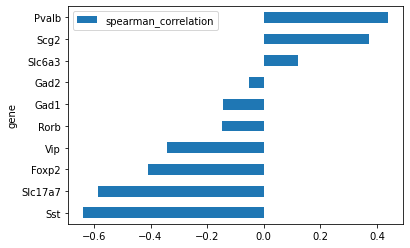

In [21]:
genes_of_interest=ISH_corr2.loc[ISH_corr2['gene'].isin(['Pvalb','Slc17a7','Slc6a3','Sst','Vip','Rorb','Foxp2',"Scg2",'Gad1','Gad2'])].sort_values('spearman_correlation')
ax =genes_of_interest.plot.barh(x='gene', y='spearman_correlation') #top 11 each way
#inspired by fig2a https://www.pnas.org/content/116/10/4689#sec-8

plt.savefig("figures/notebook_9/ALLdrugs-in21-genes-of-interest.svg")

# TOP genes (and bottom)

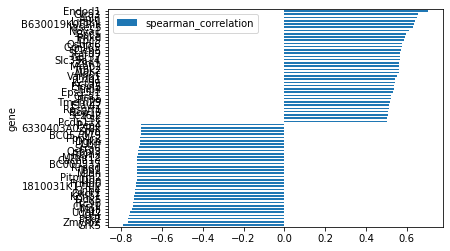

In [22]:
df_mask1=ISH_corr2['spearman_correlation']>=0.5
df_mask2=ISH_corr2['spearman_correlation']<=-0.7
top_genes=ISH_corr2[df_mask1 | df_mask2].sort_values('spearman_correlation')
ax = top_genes.plot.barh(x='gene', y='spearman_correlation') #top 11 each way
#inspired by fig2a https://www.pnas.org/content/116/10/4689#sec-8

plt.savefig("figures/notebook_9/ALLdrugs-in22-genes-top.svg")

## Above plot shows genes that are most highly correlated (positively or negatively) to the ratio of All_Drugs:control rabies data. Meaning, if the Spearman correlation is very high, for the brain regions where rabies expression in All_Drugs mice was much higher than in control mice, gene expression of that particular gene also tends to be higher in those brain regions.

## If the Spearman correlation is very low (negative), the brain regions where rabies expression in All_Drugs mice was much LOWER than in control mice are the brain regions where gene expression of that gene tended to be higher.

In [23]:
df_mask1=ISH_corr2['spearman_correlation']>=0.475#did 50. try 25 and 100.
df_mask2=ISH_corr2['spearman_correlation']<=-0.5
pos_genes=ISH_corr2[df_mask1].sort_values('spearman_correlation')
neg_genes=ISH_corr2[df_mask2].sort_values('spearman_correlation')
len(pos_genes['gene']) #Anln  	51
list(pos_genes['gene'])[-50:]
pos_genes

,gene,spearman_correlation,p_vals
1533,Gjd2,0.475188,0.034227
2442,Ndufb8,0.478195,0.032950
1375,Fgfr3,0.481203,0.031711
4137,Vegfb,0.485714,0.029921
1594,Gng11,0.487218,0.029342
3351,Sema4g,0.488722,0.028772
2690,Parm1,0.490226,0.028211
3753,Syt2,0.491729,0.027658
2417,Nap1l5,0.494737,0.026579
4195,Wrb,0.494737,0.026579


In [24]:
len(neg_genes['gene']) # 	Rbbp6
#list(neg_genes['gene'])[:50]
neg_genes[:50]

,gene,spearman_correlation,p_vals
1696,Grk5,-0.789474,0.000035
4276,Zmym2,-0.766917,0.000080
3032,Ptk2,-0.765414,0.000084
2612,Ogt,-0.762406,0.000093
4092,Uggt2,-0.756391,0.000114
2312,Mgll,-0.744361,0.000167
751,Chst1,-0.742857,0.000175
4037,Ttc9b,-0.739850,0.000192
1023,Ddx5,-0.738346,0.000201
1967,Kcnb1,-0.736842,0.000211


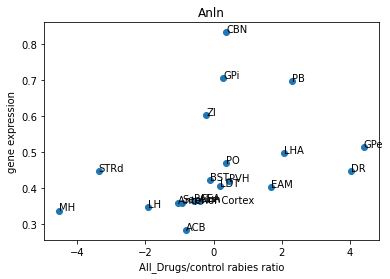

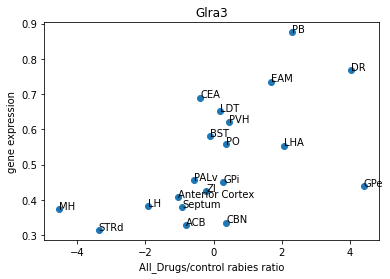

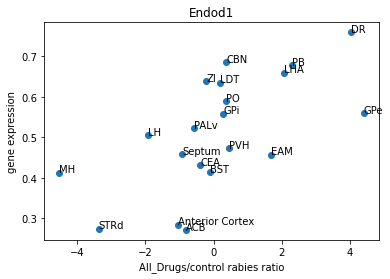

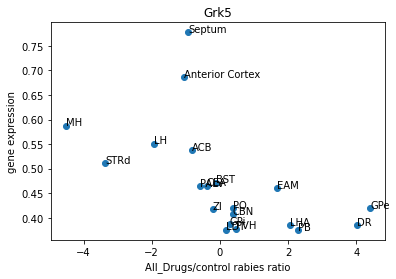

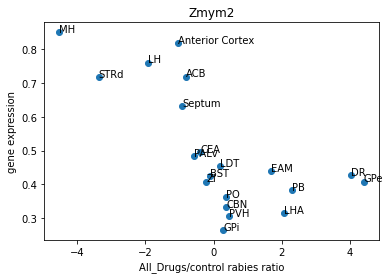

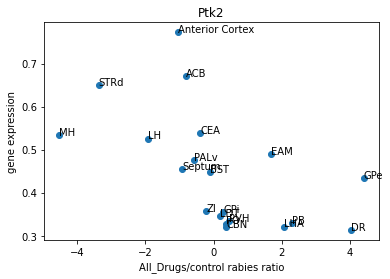

In [25]:
genes=['Anln',
 'Glra3',
 'Endod1','Grk5',
 'Zmym2',
 'Ptk2'] 
count=0
for gene in genes:
    dats=ROI_ISH_data[gene].values
    ISH_dat_list = pd.DataFrame({'brain_region': allen_regs, 'gene_exp': dats})
    temp = ISH_dat_list.groupby('brain_region').mean()  #average regions together
    dat2=temp.sort_index()['gene_exp']
    temp3 = pd.DataFrame({'ratiodat': list(ratio_df), 'gene_Dat':list(dat2)},index=labels)
    x=temp3['ratiodat'] #ratio
    y=temp3['gene_Dat'] #gene expression data
    fig, ax = plt.subplots()
    ax.scatter(x, y)
    ax.set_title(gene)
    ax.set_xlabel('All_Drugs/control rabies ratio')
    ax.set_ylabel('gene expression')
    for i, txt in enumerate(labels):
        ax.annotate(txt, (x[i], y[i]))
    count+=1 #add so next index is unique 
    figname="figures/notebook_9/ALLdrugs-in25-genes-top"+str(count)+'-'+str(gene)+'.svg'
    plt.savefig(figname)

# Positively correlated genes - All_Drugs (50 genes)

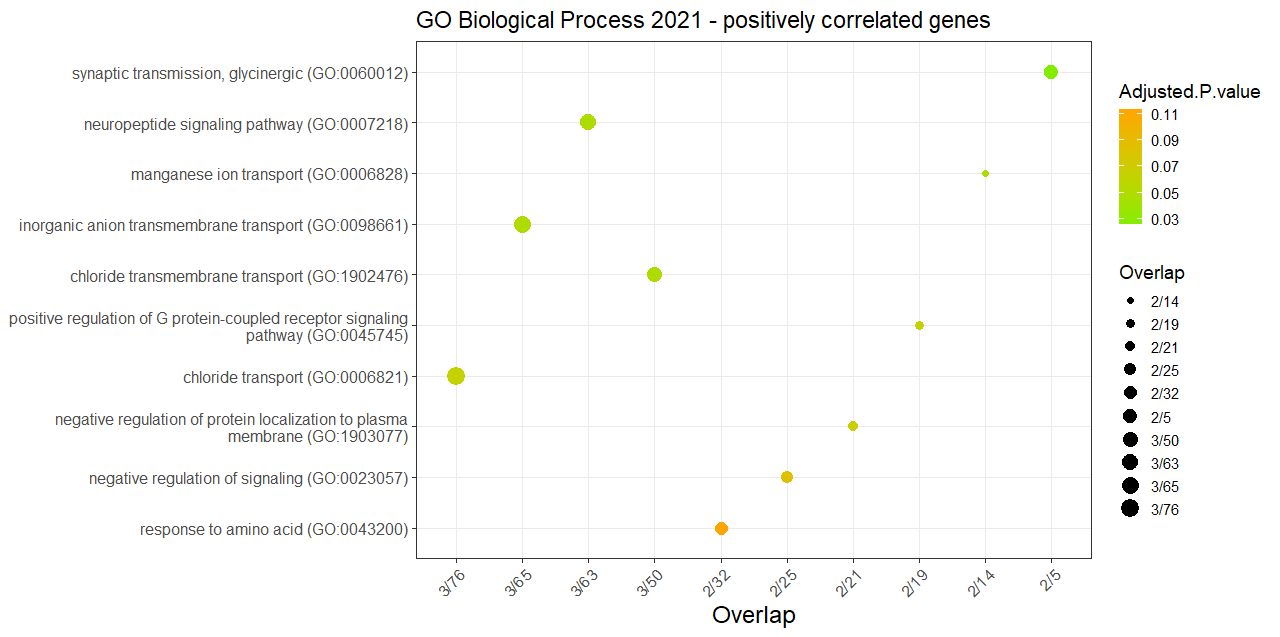

In [26]:
Image(filename='data/All_DrugsGO950_1.png')

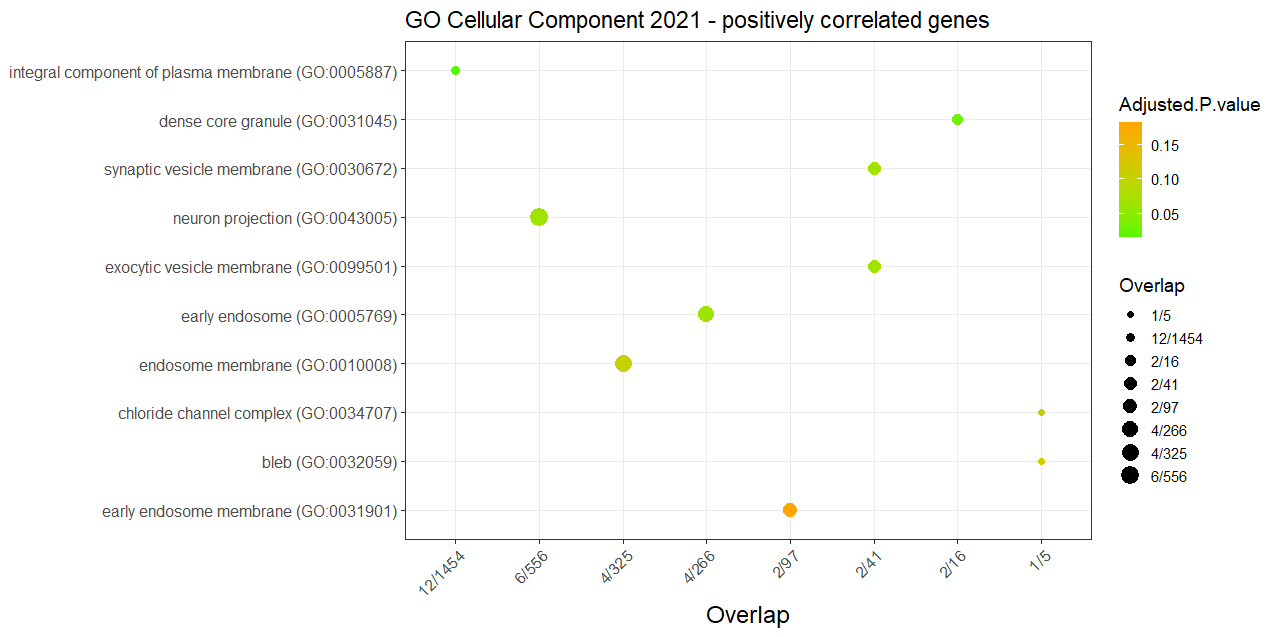

In [27]:
Image(filename='data/All_DrugsGO950_2.png')

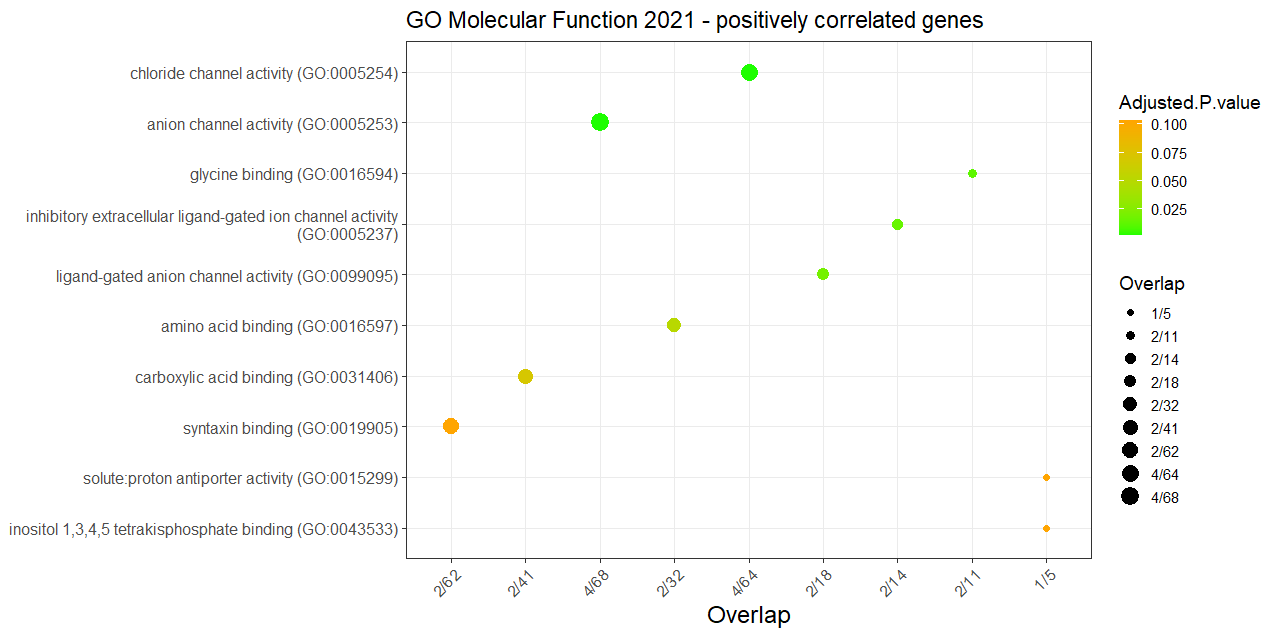

In [28]:
Image(filename='data/All_DrugsGO950_3.png')

# Negatively correlated genes - All_Drugs (50 genes)

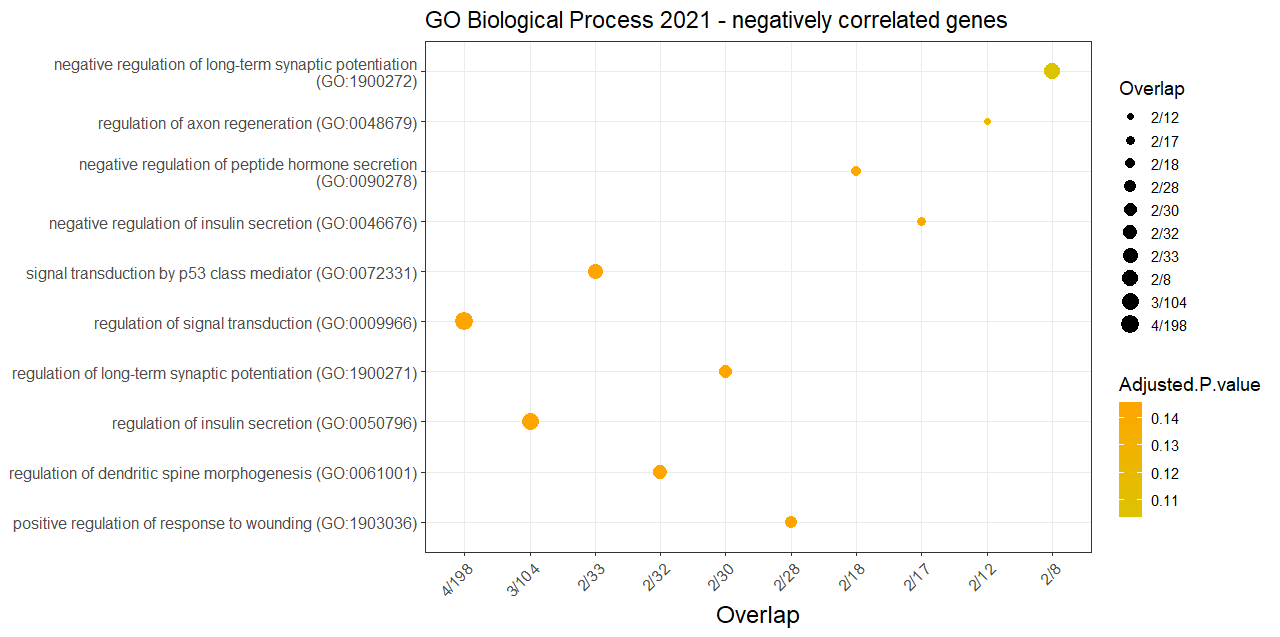

In [29]:
Image(filename='data/All_DrugsGO950_4.png')

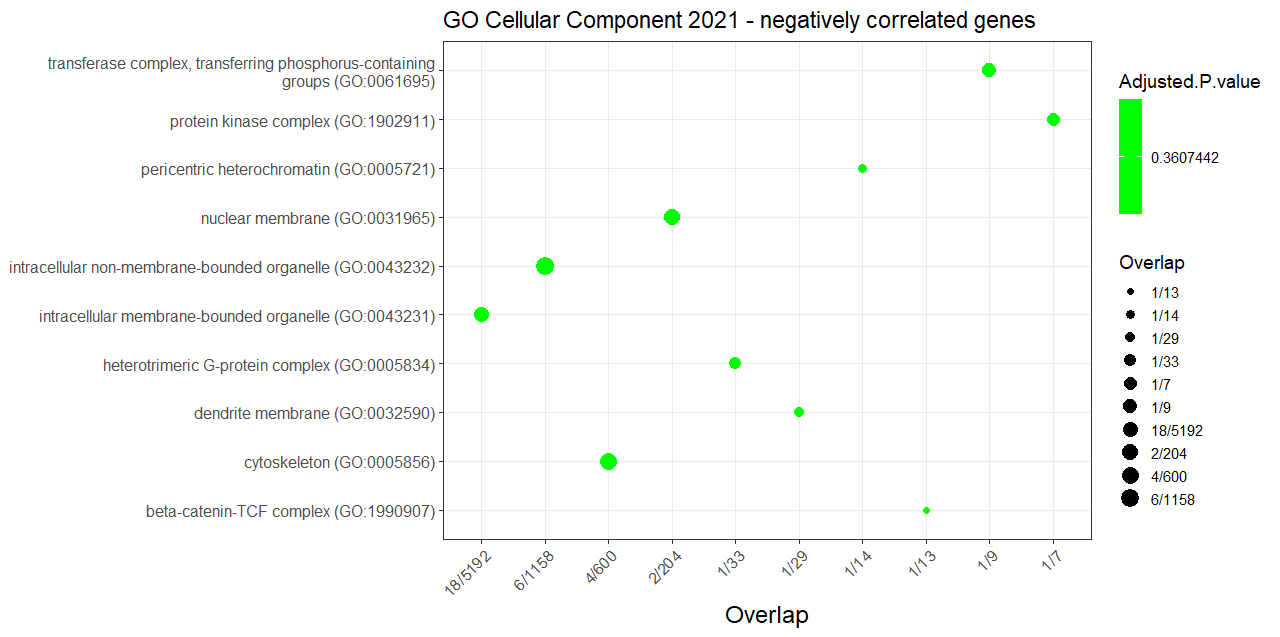

In [30]:
Image(filename='data/All_DrugsGO950_5.png')

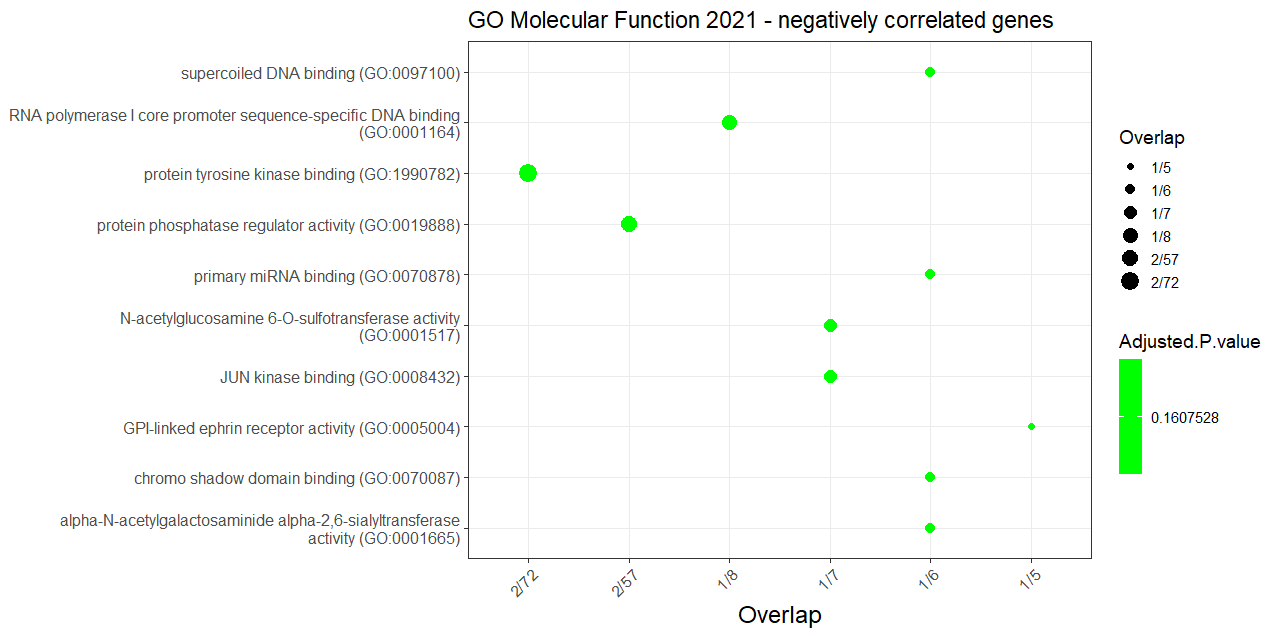

In [31]:
Image(filename='data/All_DrugsGO950_6.png')